<a href="https://colab.research.google.com/github/LambdaTheda/DS-Unit-2-Kaggle-Challenge/blob/master/1140p_Sun_Apr_19_Unit_2_u2s2m4_DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [4]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

#Explore data
df.shape # assertion above checks

df.describe()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot
count,1.395800e+04,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000
mean,2.442837e+07,270.438458,2.412380,4.727540,28.506376,17.600373,-0.554162,131.257988,0.472919,1.615561
std,7.226620e+06,169.927170,1.125828,3.331646,17.597701,10.295807,124.721869,102.666562,0.499284,10.127139
min,2.090002e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,0.000000,-39.000000
25%,2.120091e+07,109.000000,1.000000,2.000000,13.000000,8.000000,-96.000000,23.000000,0.000000,-4.000000
50%,2.150026e+07,275.500000,2.000000,4.000000,29.000000,22.000000,1.000000,141.000000,0.000000,1.000000
75%,2.170096e+07,398.000000,3.000000,7.000000,44.000000,25.000000,95.000000,219.000000,1.000000,8.000000
max,4.180040e+07,752.000000,6.000000,11.000000,59.000000,83.000000,247.000000,811.000000,1.000000,43.000000


In [5]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [6]:
# Number of unique Visiting Teams 
df['vtm'].nunique() # returns 32

32

In [7]:
# List of 32 Visiting Teams 
df['vtm'].unique()

array(['HOU', 'GSW', 'MEM', 'LAC', 'MIN', 'POR', 'LAL', 'IND', 'ORL',
       'SAS', 'WAS', 'PHX', 'BOS', 'SAC', 'CLE', 'MIA', 'MIL', 'CHI',
       'DEN', 'NJN', 'NOH', 'CHA', 'OKC', 'DAL', 'UTA', 'ATL', 'PHI',
       'DET', 'TOR', 'NYK', 'BKN', 'NOP'], dtype=object)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [8]:
# 1. Begin with baselines for classification. Your target to predict is shot_made_flag. 
#    What is your baseline accuracy, if you guessed the majority class for every prediction?

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

target = 'shot_made_flag'
''' get test in assignment 2
train, test = train_test_split(df, test_size=.2,  
                              stratify=df[target], random_state=42)
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)
'''
train, val = train_test_split(df, test_size=.2,  
                              stratify=df[target], random_state=42)

# Arrange data into X features matrix and y target vector 
columnsToDrop = [target, 'game_id', 'game_event_id', 'player_name']
X_train = train.drop(columns=columnsToDrop)
y_train = train[target]
X_val = val.drop(columns=columnsToDrop)
y_val = val[target]
#X_test = test.drop(columns=columnsToDrop)


# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

print('Majority class accuracy: 47.2919%')
print(df[target].value_counts(normalize=True)) # 47% of time Curry gets shot in

Validation Accuracy: 0.6429083094555874
Majority class accuracy: 47.2919%
0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64


## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [9]:
test = df[df['game_date'] >= '2018-10-01']
test = test.drop(columns=columnsToDrop)
test.shape

(1709, 16)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
# adding Homecourt Advantage feature
def isHomeTeam(row):
  if(row['htm'] == 'GSW'):
    return 1
  return 0

df['homecourt_advantage'] = df.apply (lambda row: isHomeTeam(row), axis=1)

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
#split
train = df[df['game_date'] >= '2009-10-01']
train = train[train['game_date'] < '2017-08-01']

val = df[df['game_date'] >= '2017-10-01']
val = val[val['game_date'] < '2018-08-01']

test = df[df['game_date'] >= '2018-10-01']

#choose which columns not to look at
columnsToDrop = [target, 'game_id', 'game_event_id', 'player_name']

#split into X and y
X_train = train.drop(columns=columnsToDrop)
y_train = train[target]

X_val = val.drop(columns=columnsToDrop) #Cross-validation with independent test set- doesn't overlap w/training set
y_val = val[target]

X_test = test.drop(columns=columnsToDrop)
y_test = test[target]

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
#fit
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [13]:
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

Validation Accuracy: 0.5907534246575342


## 7. Get your model's test accuracy

> (One time, at the end.)

In [14]:
test_pred = pipeline.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, test_pred))

Test Accuracy: 0.6225863077823288


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [15]:
num_predictions = 85 + 58 + 8 + 36
accurate_predictions = 85 + 36
print('Accuracy:', accurate_predictions/num_predictions)

Accuracy: 0.6470588235294118


### Calculate precision

In [16]:
'''
Since the assignment didn't specify whether we look for
positives or negatives, here are the precisions for both

Precision = actual outcome / predicted outcome
'''
print('Positive Precision:', 36/(58+36))
print('Negative Precision:', 85/(85+8))

Positive Precision: 0.3829787234042553
Negative Precision: 0.9139784946236559


Precision and recall are two extremely important model evaluation metrics. While **precision refers to the percentage of your results which are relevant, recall refers to the percentage of total relevant results correctly classified by your algorithm**.

May 11, 2018
towardsdatascience.com › precision-vs-recall-386cf9f89488

### Calculate recall

In [17]:
#same for recall, including false negatives

print('Positive Recall:', 36/(58+36+8))
print('Negative Recall:', 85/(85+8+58))

Positive Recall: 0.35294117647058826
Negative Recall: 0.5629139072847682


------------------------------------------
#**Stretch Goals:** 
1) Engineer 4+ new features total, either from the list above, or your own ideas.

2) Make 2+ visualizations to explore relationships between features and target.

3) Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters).
   You can use RandomizedSearchCV or do it manually.

4) Get and plot your model's feature importances.

### 1) Engineer 4+ new features total, either from the list above, or your own ideas.


**Feature #1**

In [18]:
# adding 'isScrimmage' column: are the Golden State Warriors playing against themselves?

def isOpponentGSW(row):
  if(row['vtm'] != 'GSW'):
    return 'No'   # if NOT 'GSW'
  return 'Yes'    # if 'GSW', ie, perhaps scrimmaging against teammates

df['isScrimmage?'] = df.apply(lambda row: isOpponentGSW(row), axis=1)

df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage,isScrimmage?
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,No
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1,No
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,No
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,No
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,2019-06-05,GSW,TOR,Playoffs,-13.0,1,No
13954,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,2019-06-05,GSW,TOR,Playoffs,-14.0,1,No
13955,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,2019-06-05,GSW,TOR,Playoffs,-17.0,1,No
13956,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,2019-06-05,GSW,TOR,Playoffs,-16.0,1,No


**Feature #2**

In [19]:
# Add 'otherTeamName' column: if vtm is NOT GWS, ie, NOT indicative of a scrimmage

def otherTeam(row):
  if (row['isScrimmage?'] == 'No'):
     return row['vtm']
  return 'Scrimmage'

#df['isScrimmage?'] = df.apply(lambda row: isScrimmage(row), axis =1) 

df['otherTeam'] = df.apply(lambda row: otherTeam(row), axis = 1)
 
df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage,isScrimmage?,otherTeam
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,No,HOU
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1,No,HOU
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,No,HOU
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,No,HOU
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1,No,HOU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,2019-06-05,GSW,TOR,Playoffs,-13.0,1,No,TOR
13954,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,2019-06-05,GSW,TOR,Playoffs,-14.0,1,No,TOR
13955,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,2019-06-05,GSW,TOR,Playoffs,-17.0,1,No,TOR
13956,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,2019-06-05,GSW,TOR,Playoffs,-16.0,1,No,TOR


**Feature #3**

In [20]:
# adding 'GLORY SHOT' column, Yes: if 'seconds_remaining' <= 10  or No > 10 

def isGloryShot(row):
  if(row['seconds_remaining'] <= 10):
    return 'Yes'
  return 'No'

df['isGloryShot?'] = df.apply(lambda row: isGloryShot(row), axis = 1) 

df

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage,isScrimmage?,otherTeam,isGloryShot?
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,No,HOU,No
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1,No,HOU,No
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,No,HOU,Yes
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,No,HOU,No
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1,No,HOU,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13953,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,2019-06-05,GSW,TOR,Playoffs,-13.0,1,No,TOR,Yes
13954,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,2019-06-05,GSW,TOR,Playoffs,-14.0,1,No,TOR,No
13955,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,2019-06-05,GSW,TOR,Playoffs,-17.0,1,No,TOR,No
13956,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,2019-06-05,GSW,TOR,Playoffs,-16.0,1,No,TOR,No


**Feature #4**

In [21]:
# adding 'HERO SHOT' column, Yes: if 'seconds_remaining' <= 10  AND 'shot_made_flag' == 1  AND 'scoremargin_before_shot'  < 3.
 
def isHeroShot(row):
# if((row['seconds_remaining'] <= 10) and (row['scoremargin_before_shot'] < 3)): # and operator for if statements conds 1 and 2
  if((row['seconds_remaining'] <= 10) & (row['scoremargin_before_shot'] < 3)): # bit-wise operator does & operation.. to select certain rows in a df ..like dereferencing, for #s n chking on rows 
  
  # if()
    return 'Yes'
  return 'No'

df['isHeroShot?'] = df.apply(lambda row: isHeroShot(row), axis = 1)  

df.sample(35)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,homecourt_advantage,isScrimmage?,otherTeam,isGloryShot?,isHeroShot?
6026,21400382,46,Stephen Curry,1,7,7,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,25,-70,244,0,2014-12-18,GSW,OKC,Regular Season,-10.0,1,No,OKC,Yes,Yes
8623,21500981,111,Stephen Curry,1,0,34,Pullup Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,26,-65,259,1,2016-03-12,GSW,PHX,Regular Season,4.0,1,No,PHX,No,No
2619,21200126,238,Stephen Curry,2,0,51,Driving Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,9,4,1,2012-11-16,MIN,GSW,Regular Season,-3.0,0,Yes,Scrimmage,No,No
1499,21000477,282,Stephen Curry,3,8,57,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,17,171,31,1,2010-12-31,CHA,GSW,Regular Season,7.0,0,Yes,Scrimmage,No,No
12318,21800047,53,Stephen Curry,1,6,24,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,214,125,0,2018-10-22,GSW,PHX,Regular Season,1.0,1,No,PHX,No,No
2320,21100284,552,Stephen Curry,4,0,28,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-2,7,1,2012-01-27,GSW,OKC,Regular Season,-11.0,1,No,OKC,No,No
6133,21400518,138,Stephen Curry,1,3,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,22,-188,119,0,2015-01-05,GSW,OKC,Regular Season,8.0,1,No,OKC,No,No
5370,21301123,190,Stephen Curry,2,4,43,Pullup Jump shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,17,-15,170,1,2014-04-02,SAS,GSW,Regular Season,-14.0,0,Yes,Scrimmage,No,No
13184,21800892,454,Stephen Curry,3,5,37,Jump Shot,3PT Field Goal,Left Corner 3,Left Side(L),24+ ft.,22,-228,-6,1,2019-02-23,GSW,HOU,Regular Season,-1.0,1,No,HOU,No,No
9897,21600520,112,Stephen Curry,1,0,53,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,1,11,1,2017-01-02,GSW,DEN,Regular Season,-1.0,1,No,DEN,No,No


###2) Make 2+ visualizations to explore relationships between features and target.


**(i) Correlation Explorations**

In [22]:
df.corr()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot,homecourt_advantage
game_id,1.000000,0.058387,0.023757,-0.018650,-0.009982,0.019789,-0.007311,0.016984,-0.017542,-0.022761,0.006558
game_event_id,0.058387,1.000000,0.940855,-0.291271,-0.018433,0.011211,0.037097,0.029789,-0.012720,0.096800,-0.038768
period,0.023757,0.940855,1.000000,-0.071512,0.009031,-0.014679,0.040834,0.002066,-0.005241,0.076163,-0.008206
minutes_remaining,-0.018650,-0.291271,-0.071512,1.000000,0.037336,-0.053699,-0.012034,-0.078049,0.033877,-0.084498,-0.002664
seconds_remaining,-0.009982,-0.018433,0.009031,0.037336,1.000000,-0.064230,-0.010662,-0.068568,0.036618,-0.007952,0.013011
shot_distance,0.019789,0.011211,-0.014679,-0.053699,-0.064230,1.000000,-0.017901,0.822426,-0.138070,0.025137,0.041477
loc_x,-0.007311,0.037097,0.040834,-0.012034,-0.010662,-0.017901,1.000000,0.036513,-0.005824,0.013601,-0.018087
loc_y,0.016984,0.029789,0.002066,-0.078049,-0.068568,0.822426,0.036513,1.000000,-0.130082,0.018910,0.063964
shot_made_flag,-0.017542,-0.012720,-0.005241,0.033877,0.036618,-0.138070,-0.005824,-0.130082,1.000000,-0.003207,0.016526
scoremargin_before_shot,-0.022761,0.096800,0.076163,-0.084498,-0.007952,0.025137,0.013601,0.018910,-0.003207,1.000000,0.139805


In [23]:
corr = df.corr()
print(corr)

                          game_id  ...  homecourt_advantage
game_id                  1.000000  ...             0.006558
game_event_id            0.058387  ...            -0.038768
period                   0.023757  ...            -0.008206
minutes_remaining       -0.018650  ...            -0.002664
seconds_remaining       -0.009982  ...             0.013011
shot_distance            0.019789  ...             0.041477
loc_x                   -0.007311  ...            -0.018087
loc_y                    0.016984  ...             0.063964
shot_made_flag          -0.017542  ...             0.016526
scoremargin_before_shot -0.022761  ...             0.139805
homecourt_advantage      0.006558  ...             1.000000

[11 rows x 11 columns]


In [24]:
# Correlation Matrix
corr.style.background_gradient(cmap = 'viridis')

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot,homecourt_advantage
game_id,1.000000,0.058387,0.023757,-0.018650,-0.009982,0.019789,-0.007311,0.016984,-0.017542,-0.022761,0.006558
game_event_id,0.058387,1.000000,0.940855,-0.291271,-0.018433,0.011211,0.037097,0.029789,-0.012720,0.096800,-0.038768
period,0.023757,0.940855,1.000000,-0.071512,0.009031,-0.014679,0.040834,0.002066,-0.005241,0.076163,-0.008206
minutes_remaining,-0.018650,-0.291271,-0.071512,1.000000,0.037336,-0.053699,-0.012034,-0.078049,0.033877,-0.084498,-0.002664
seconds_remaining,-0.009982,-0.018433,0.009031,0.037336,1.000000,-0.064230,-0.010662,-0.068568,0.036618,-0.007952,0.013011
shot_distance,0.019789,0.011211,-0.014679,-0.053699,-0.064230,1.000000,-0.017901,0.822426,-0.138070,0.025137,0.041477
loc_x,-0.007311,0.037097,0.040834,-0.012034,-0.010662,-0.017901,1.000000,0.036513,-0.005824,0.013601,-0.018087
loc_y,0.016984,0.029789,0.002066,-0.078049,-0.068568,0.822426,0.036513,1.000000,-0.130082,0.018910,0.063964
shot_made_flag,-0.017542,-0.012720,-0.005241,0.033877,0.036618,-0.138070,-0.005824,-0.130082,1.000000,-0.003207,0.016526
scoremargin_before_shot,-0.022761,0.096800,0.076163,-0.084498,-0.007952,0.025137,0.013601,0.018910,-0.003207,1.000000,0.139805


**Correlation Heatmap**

'\n# Using corr from previous cell: same output, mais bien sur\n\ncorr = df.corr()\nf, ax = plt.subplots(figsize=(12, 9))\nsns.heatmap(corr, vmax=.8, square=True);\n'

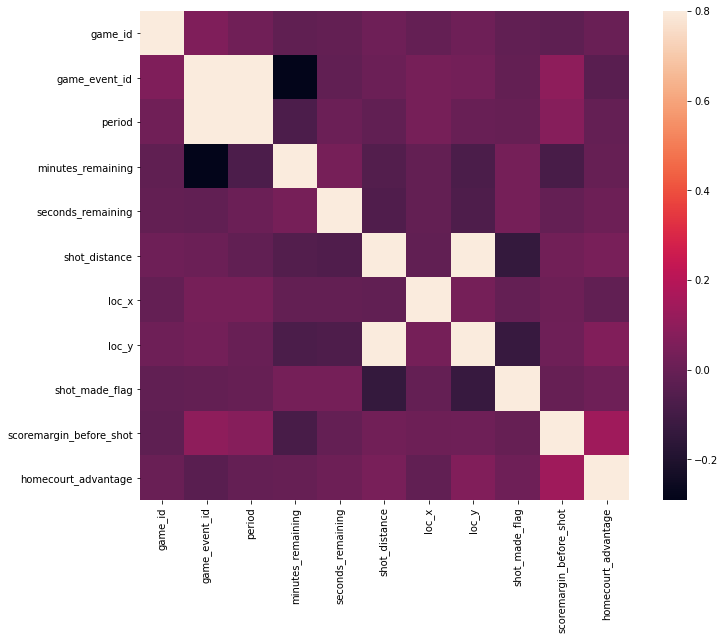

In [25]:
# using https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
import seaborn as sns
import matplotlib.pyplot as plt

corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

'''
# Using corr from previous cell: same output, mais bien sur

corr = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True);
'''

**Partial Dependence Plot**

In [26]:
!pip install pdpbox

from pdpbox.pdp import pdp_interact, pdp_interact_plot

     |████████████████████████████████| 57.7MB 82kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=421d0f42da3ee51befec1b47b6dcab643a746996d5aa6d5c28fa9a8c55abba9a
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [27]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 -0.005922007689495246


(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2ffea06358>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2ffea0d860>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


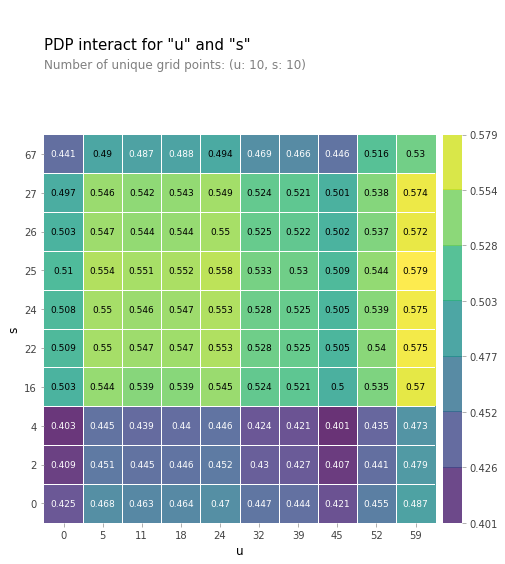

In [28]:
# Select target column and another feature column to  see their interdependence
#use_features = ['shot_made_flag', 'shot_distance'] # target = 'shot_made_flag' here; getting ValueError: feature does not exist: shot_made_flag

#try different target
use_features = ['seconds_remaining', 'shot_distance']
interaction = pdp_interact(
    model = gb,
    dataset = X_val, # because score on Validataion set?
    model_features = X_val.columns,
    features = use_features

)

pdp_interact_plot(interaction, plot_type = 'grid', feature_names = 'use_features')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


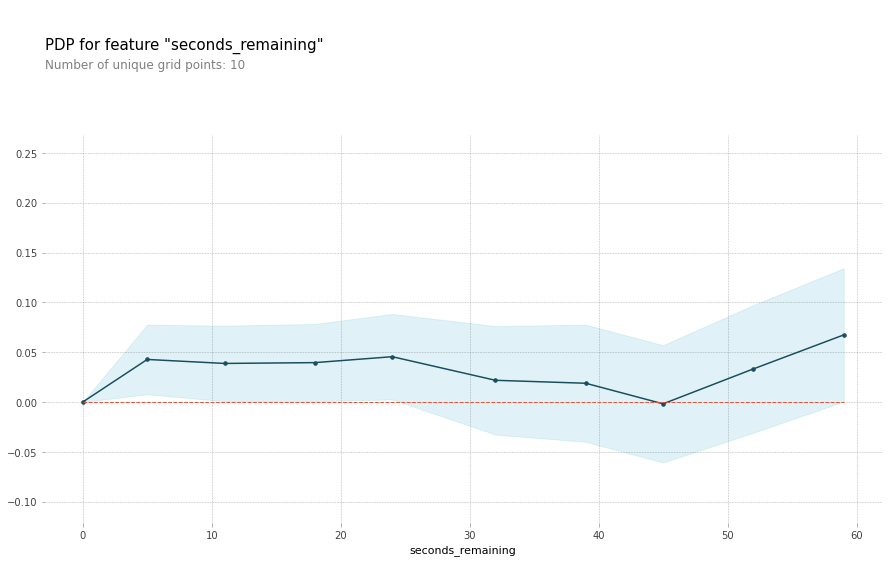

In [29]:
# Use Pdpbox
!pip install Pdpbox

%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'seconds_remaining'
pdp_dist = pdp.pdp_isolate(model=gb, dataset=X_val, model_features=X_val.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [0]:
# pdp.pdp_plot()..  ERR: missing ..isolate() and...

In [31]:
print(df['shot_made_flag'])

0        0
1        1
2        0
3        0
4        0
        ..
13953    1
13954    0
13955    0
13956    0
13957    0
Name: shot_made_flag, Length: 13958, dtype: int64


## 3) Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use RandomizedSearchCV or do it manually.

### a) Trying to Redo Validation using RandomizedSearchCV...

In [32]:
# ATTEMPT 1: using: https://colab.research.google.com/drive/1Ef4rT81DajicLyy_zl20m894z-JWeYQ4
'''
RandomForestClassifier()

pipe = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1)
)

search = RandomizedSearchCV(
    pipe,
    param_distributions={
        "simpleimputer__strategy": ["mean", "median"],
        "randomforestclassifier__max_depth": [15, 20, 25, 30, 50, None]
    },
    n_iter=10,
    cv=3,
    verbose=10,
)
search.fit(X_train, y_train)
'''

'\nRandomForestClassifier()\n\npipe = make_pipeline(\n    SimpleImputer(),\n    RandomForestClassifier(n_jobs=-1)\n)\n\nsearch = RandomizedSearchCV(\n    pipe,\n    param_distributions={\n        "simpleimputer__strategy": ["mean", "median"],\n        "randomforestclassifier__max_depth": [15, 20, 25, 30, 50, None]\n    },\n    n_iter=10,\n    cv=3,\n    verbose=10,\n)\nsearch.fit(X_train, y_train)\n'

In [33]:
#ATTEMPT 2:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestclassifier__n_estimators": randint(50, 1000),
    "randomforestclassifier__max_depth": [10, 15, 25, 40, None],
    "randomforestclassifier__max_features": uniform(0, 1),
}

pipe = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1),
)

search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    n_iter=100,
    cv=3,
    scoring="accuracy",
    verbose=10,
)

search.fit(X_val, y_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.20611580423902753, randomforestclassifier__n_estimators=299, simpleimputer__strategy=mean 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.20611580423902753, randomforestclassifier__n_estimators=299, simpleimputer__strategy=mean, score=nan, total=   0.0s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.20611580423902753, randomforestclassifier__n_estimators=299, simpleimputer__strategy=mean 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.20611580423902753, randomforestclassifier__n_estimators=299, simpleimputer__strategy=mean, score=nan, total=   0.0s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=0.20611580423902753, randomforestclassifier__n_estimators=299, simpleimputer__strategy=mean 
[CV]  randomforestcl

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.8540265168799748, randomforestclassifier__n_estimators=351, simpleimputer__strategy=median, score=nan, total=   0.0s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.9937900195029917, randomforestclassifier__n_estimators=163, simpleimputer__strategy=mean 
[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.9937900195029917, randomforestclassifier__n_estimators=163, simpleimputer__strategy=mean, score=nan, total=   0.0s
[CV] randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.9937900195029917, randomforestclassifier__n_estimators=163, simpleimputer__strategy=mean 
[CV]  randomforestclassifier__max_depth=25, randomforestclassifier__max_features=0.9937900195029917, randomforestclassifier__n_estimators=163, simpleimputer__strategy=mean, score=nan, total=   0.0s
[CV] randomforestclassifier__max_depth=25, randomforestclass

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.3s finished


ValueError: ignored

In [0]:
#ATTEMPT 3: ValueError: could not convert string to float: 'Stephen Curry'pipe = make_pipeline(  - TRY ORDINAL ENCODER?
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1)
)

search = RandomizedSearchCV(
    pipe,
    param_distributions={
        "simpleimputer__strategy": ["most_frequent"],
        "randomforestclassifier__max_depth": [15, 20, 25, 30, 50, None]
    },
    n_iter=10,
    cv=3,
    verbose=10,
)
search.fit(X_train, y_train)

In [0]:
search.best_params_

In [0]:
impute = SimpleImputer()


X_train = impute.fit_transform(X_train)
X_test = impute.transform(X_test)

# manual grid search
for x in range(15, 50, 5):
    clas = RandomForestClassifier(n_jobs=-1, max_depth=x)
    clas.fit(X_train, y_train)
    score = clas.score(X_test, y_test)
    print(f"{x}: {score}")

In [0]:
'''
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=511)
'''

In [0]:
'''
target = 'seconds_remaining'
features = train.columns.drop([target])

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]
'''

In [0]:
'''
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),
    RandomForestClassifier(n_jobs=-1),
)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
'''

In [0]:
#df['seconds_remaining'].dtype


### b) Trying to Hyperparameter Tuning Manually

In [0]:
''' 
ATTEMPT 1: GETTING ERRS trying to add more hyperparameters: max_depth, max_features?
# from above cell [115] & modified using eric's TL help ntbk: Optimize 3+ hyperparameters by trying 10+ "candidates"

# only had these 3 hyperparameters @ start:  RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 

# add max_depth, max_features?
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators = 100, max_depth = 30, random_state=42, n_jobs=-1)
)
#fit
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
'''

In [0]:
'''
# ATTEMPT 2: ValueError: Unexpected input dimension 17, expected 24
#from above cell [115] & modified using eric's TL help ntbk: Optimize 3+ hyperparameters by trying 10+ "candidates"

# only had these 3 hyperparameters @ start:  RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 

# add max_depth, max_features?
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
)
#fit
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
'''

In [0]:
# using: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from pprint import pprint

rf = RandomForestClassifier(random_state = 42)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

"""
Returns: ?? n_jobs was set to -1 as shown in [147]

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
 '''

### 4) Get and plot your model's feature importances.

In [42]:
#Get and Plot Feature Importances- this cell from Permut & Boost, Feat Impt DS_U2 S3 M3.ipynb; https://colab.research.google.com/drive/1HgxUaxU7xqEAr7ZSciLKkt8PRaH96SmT
#decisTreeClsfr = pipeline.named_steps['decisiontreeclassifier']
#encoder = pipeline.named_steps['onehotencoder']
#encoded_columns = encoder.transform(X_val).columns # before encoding columns, got "ValueError: Length of passed values is 185, index implies 31" when trying to use: importances = pd.Series(decisTreeClsfr.feature_importances_, X_train.columns)

decisTreeClsfr = pipeline
importances = pd.Series(decisTreeClsfr.feature_importances_, encoded_columns)

#importances = pipeline.fit(X_train, y_train)

#Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color = 'green')

AttributeError: ignored